Analyzing dataset in: /mnt/Common/Code/Model Training/Nowshin/Bengali License Plate Detection/Bangladeshi_Vehicle_Image_with_visible_license_plate
No data.yaml provided, so class IDs will be displayed.
Will attempt to show up to 5 examples per class, with 5 images per row.

Scanned 1929 image-label pairs for unique classes.

--- Skipped Files Details ---
- Label 'classes.txt' skipped: No corresponding image file found for 'classes'.
- Label 'Vehicle1717.txt' skipped: No corresponding image file found for 'Vehicle1717'.
- Label 'Vehicle1715.txt' skipped: No corresponding image file found for 'Vehicle1715'.
- Label 'Vehicle1716.txt' skipped: No corresponding image file found for 'Vehicle1716'.
- Label 'Vehicle1718.txt' skipped: No corresponding image file found for 'Vehicle1718'.
- Label 'Vehicle1719.txt' skipped: No corresponding image file found for 'Vehicle1719'.
Skipped 0 label files due to read errors.

Found 1 unique classes with at least one example.

--- Class Distribution Table 

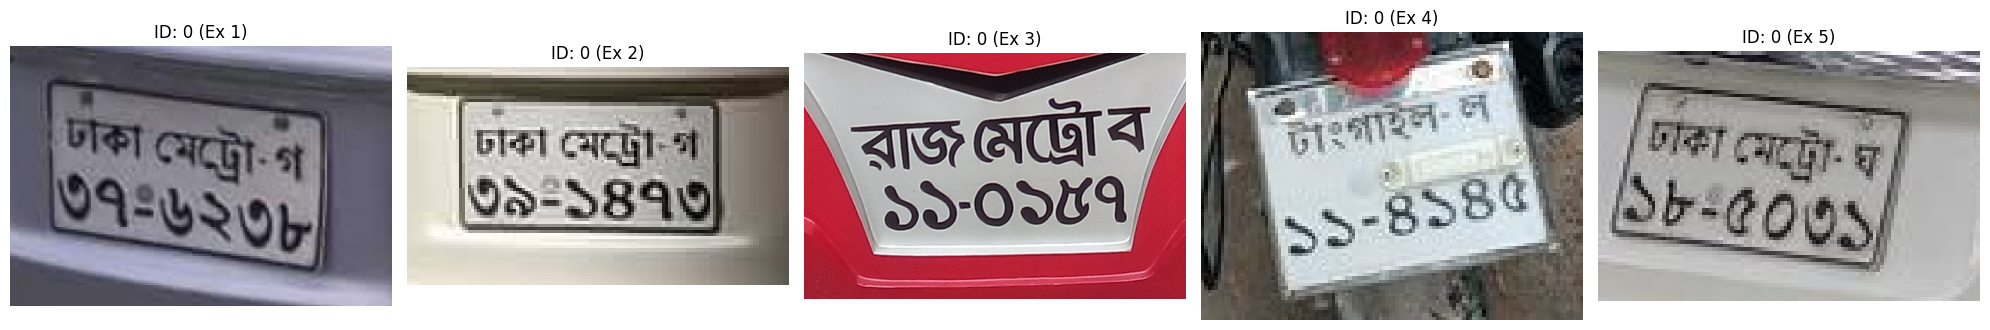


--- Exporting Classes JSON ---
Successfully exported unique class IDs to 'classes2.json'
The JSON is in the format {class_id: "class_name"}.
You can now open this file to manually add meaningful class names after reviewing the cropped images.

Finished processing dataset.


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# --- Configuration Variables (Modify these as needed) ---

# Path to your input dataset folder containing both images and label files
# Example: 'Bangla_License_Plate'
input_dataset_folder = 'Bangladeshi_Vehicle_Image_with_visible_license_plate'

# List of supported image file extensions (case-insensitive)
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Label file extension (YOLO format)
label_extension = '.txt'

# Output file path for the classes JSON
# This file will be created in the same directory as your Jupyter notebook/script.
json_output_path = 'classes2.json'

# --- Display Configuration ---
# Number of example images to display for each unique class.
# If a class has fewer instances than this number, it will display all available.
num_examples_per_class = 5 

# Number of images to display per row in the matplotlib plot.
plot_cols = 5 

# --- End of Configuration Variables ---

print(f"Analyzing dataset in: {os.path.abspath(input_dataset_folder)}")
print("No data.yaml provided, so class IDs will be displayed.")
print(f"Will attempt to show up to {num_examples_per_class} examples per class, with {plot_cols} images per row.")

# --- 1. Collect examples (up to num_examples_per_class) and class counts for each unique class ---
# Stores: {class_id: [(image_path, bbox_data), (image_path, bbox_data), ...]}
class_examples = defaultdict(list) 
# Stores: {class_id: count_of_instances}
class_counts = defaultdict(int) 

processed_files = 0
skipped_files_details = [] 
skipped_due_to_read_error = 0

for filename in os.listdir(input_dataset_folder):
    file_path = os.path.join(input_dataset_folder, filename)

    if os.path.isfile(file_path):
        base_name, ext = os.path.splitext(filename)
        ext = ext.lower()

        if ext in image_extensions:
            image_path = file_path
            label_file_path = os.path.join(input_dataset_folder, base_name + label_extension)

            if os.path.exists(label_file_path):
                processed_files += 1
                try:
                    with open(label_file_path, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            parts = list(map(float, line.strip().split()))
                            if len(parts) == 5:
                                class_id = int(parts[0])
                                # Increment total count for this class
                                class_counts[class_id] += 1
                                # Only store example if we haven't reached the limit for this class
                                if len(class_examples[class_id]) < num_examples_per_class:
                                    class_examples[class_id].append((image_path, parts[1:])) # Store normalized bbox
                            else:
                                print(f"Warning: Malformed line in {label_file_path}: '{line.strip()}'")
                except Exception as e:
                    skipped_due_to_read_error += 1
                    print(f"Error reading label file {label_file_path}: {e}")
            else:
                skipped_files_details.append(f"Image '{filename}' skipped: No corresponding label file '{os.path.basename(label_file_path)}' found.")
        elif ext == label_extension:
            # Check if this label has a corresponding image (if not, it's irrelevant for this task)
            image_found_for_label = False
            for img_ext in image_extensions:
                if os.path.exists(os.path.join(input_dataset_folder, base_name + img_ext)):
                    image_found_for_label = True
                    break
            if not image_found_for_label:
                skipped_files_details.append(f"Label '{filename}' skipped: No corresponding image file found for '{base_name}'.")

print(f"\nScanned {processed_files} image-label pairs for unique classes.")
if skipped_files_details:
    print("\n--- Skipped Files Details ---")
    for detail in skipped_files_details:
        print(f"- {detail}")
else:
    print("No files were skipped due to missing pairs.")
print(f"Skipped {skipped_due_to_read_error} label files due to read errors.")

print(f"\nFound {len(class_examples)} unique classes with at least one example.")

# --- Display Class Distribution Table ---
print("\n--- Class Distribution Table ---")
if class_counts:
    print(f"{'Class ID':<10}{'Count':<10}{'Percentage':<15}")
    print("-" * 35)
    total_annotations = sum(class_counts.values())
    sorted_class_counts = sorted(class_counts.items())

    for class_id, count in sorted_class_counts:
        percentage = (count / total_annotations) * 100 if total_annotations > 0 else 0
        print(f"{class_id:<10}{count:<10}{percentage:.2f}%")
    print("-" * 35)
    print(f"{'Total':<10}{total_annotations:<10}{100.00:.2f}%")
else:
    print("No annotations found to calculate distribution.")


if not class_examples:
    print("No classes found or no valid annotations in the dataset to display crops.")
else:
    # --- 2. Crop and Display Regions for Each Class ---
    print("\nDisplaying cropped regions for each unique class:")

    # Sort class IDs for consistent display order
    sorted_class_ids = sorted(class_examples.keys())

    # Calculate the total number of subplots needed
    total_subplots_to_display = 0
    for class_id in sorted_class_ids:
        total_subplots_to_display += len(class_examples[class_id]) # Add all collected examples for this class

    # Dynamically determine the number of rows for the subplot grid
    rows = (total_subplots_to_display + plot_cols - 1) // plot_cols

    plt.figure(figsize=(plot_cols * 4, rows * 4)) # Adjust figure size based on grid
    plot_index = 1 # Keep track of the current subplot position

    for class_id in sorted_class_ids:
        current_class_examples = class_examples[class_id]
        
        for example_idx, (image_path, bbox_data) in enumerate(current_class_examples):
            # Load the image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Warning: Could not load image '{os.path.basename(image_path)}' for Class ID {class_id}. Skipping display for this specific example.")
                continue

            h, w, _ = img.shape

            # Convert normalized bbox to pixel coordinates
            x_center, y_center, bbox_width, bbox_height = bbox_data
            
            x1 = int((x_center - bbox_width / 2) * w)
            y1 = int((y_center - bbox_height / 2) * h)
            x2 = int((x_center + bbox_width / 2) * w)
            y2 = int((y_center + bbox_height / 2) * h)

            # Ensure coordinates are within image bounds to prevent errors
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)

            # Crop the image
            cropped_img = img[y1:y2, x1:x2]

            # Handle cases where cropping results in an empty image (e.g., tiny or out-of-bounds bbox)
            if cropped_img.shape[0] == 0 or cropped_img.shape[1] == 0:
                print(f"Warning: Cropped region for Class ID {class_id} from '{os.path.basename(image_path)}' is empty/invalid (bbox: {bbox_data}). Skipping display.")
                continue

            # Display the cropped image
            ax = plt.subplot(rows, plot_cols, plot_index)
            ax.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
            ax.set_title(f"ID: {class_id} (Ex {example_idx + 1})")
            ax.axis('off') # Hide axes for cleaner display
            plot_index += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

    # --- 3. Export classes.json in {serial: "character"} format ---
    print("\n--- Exporting Classes JSON ---")
    classes_dict = {}
    for class_id in sorted_class_ids:
        # Use a placeholder like "Class X"
        classes_dict[str(class_id)] = f"Class {class_id}" 

    try:
        with open(json_output_path, 'w', encoding='utf-8') as f:
            # Use ensure_ascii=False to correctly write Bengali characters if you manually add them
            json.dump(classes_dict, f, indent=2, ensure_ascii=False)
        print(f"Successfully exported unique class IDs to '{json_output_path}'")
        print("The JSON is in the format {class_id: \"class_name\"}.")
        print("You can now open this file to manually add meaningful class names after reviewing the cropped images.")
    except Exception as e:
        print(f"Error exporting JSON to '{json_output_path}': {e}")

print("\nFinished processing dataset.")